In [1]:
%matplotlib nbagg
#from photodiag import PalmSetup
import photodiag
import json
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import h5py
import os, glob


from scipy.special import erf
from scipy.optimize import curve_fit
from alvra_tools import load_data
from IPython.display import clear_output

# First part: load a THz scan to calibrate the eV to fs slope

### First look for the correct PALM calibration file

In [2]:
#DIRcalib = '/sf/photo/src/PALM/calib/'
DIRcalib = '/sf/photo/src/PALM/calib/Alvra'
DIRcalib = '/sf/alvra/data/p18442/res/PhotoDiag/scan_info/'

!ls -lah -rt $DIRcalib | grep palm_etof

-rw-r--r--. 1 39147 p18442 254K Jan 30 12:21 2020-01-30_12:21:54.palm_etof
-rw-r--r--. 1 39147 p18442 254K Jan 31 17:42 2020-01-31_17:42:38.palm_etof
-rw-r--r--. 1 39147 p18442 254K Feb  1 20:28 2020-02-01_20:28:09.palm_etof


### Now load the calibration file and give the energy range

In [3]:
#CalibrationFn = DIRcalib + '2019-05-24_13:40:42.palm_etof'     # 12 keV settings
CalibrationFn = DIRcalib + '2020-01-31_17:42:38.palm_etof'     # 5 keV settings -- p18182

energyFrom =  1200
energyTo =    1500
energySteps = 2000

###########################################################################################

palm = photodiag.PalmSetup({'0': 'SAROP11-PALMK118:CH1_BUFFER', '1': 'SAROP11-PALMK118:CH2_BUFFER'},
                 noise_range=[0, 250],
                 energy_range=np.linspace(energyFrom, energyTo, energySteps))

palm.load_etof_calib(CalibrationFn)    

# define the fitfunction
def fitThz(x, a, b, c, d, e, f):
    return a + b*np.exp(-(c-x)**2/np.abs(d)**2)*np.sin(e*x + f) 


### Now choose the directory of the json file for the THz scan

In [4]:
DIRjson = "/sf/alvra/data/p18442/res/PhotoDiag/scan_info/"

!ls -lah -rt $DIRjson | grep json

-rw-r--r--. 1 39147 p18442 3.8K Jan 30 12:14 PALM_calib_100_scan_info.json
-rw-r--r--. 1 39147 p18442 3.3K Jan 30 12:25 PALM_resol_001_scan_info.json
-rw-r--r--. 1 39147 p18442 3.3K Jan 30 12:27 PALM_resol_002_scan_info.json
-rw-r--r--. 1 39147 p18442 3.3K Jan 30 12:28 PALM_resol_003_scan_info.json
-rw-r--r--. 1 39147 p18442 3.3K Jan 30 12:29 PALM_resol_004_scan_info.json
-rw-r--r--. 1 39147 p18442 2.8K Jan 30 18:17 PALM_scan_001_scan_info.json
-rw-r--r--. 1 39147 p18442 2.8K Jan 30 18:21 PALM_scan_002_scan_info.json
-rw-r--r--. 1 39147 p18442 2.8K Jan 30 18:24 PALM_scan_003_scan_info.json
-rw-r--r--. 1 39147 p18442 7.3K Jan 30 18:30 PALM_scan_004_scan_info.json
-rw-r--r--. 1 39147 p18442 7.3K Jan 31 16:59 PALM_scan_005_scan_info.json
-rw-r--r--. 1 39147 p18442 7.3K Jan 31 17:05 PALM_scan_006_scan_info.json
-rw-r--r--. 1 39147 p18442 7.3K Jan 31 17:14 PALM_scan_007_scan_info.json
-rw-r--r--. 1 39147 p18442 7.3K Jan 31 17:35 PALM_scan_008_scan_info.json
-rw-r--r--. 1 39147 p18442 7.3K J

 ### Load the THz scan

In [5]:
scan_name = 'PALM_scan_010'

###########################################

fn_json = DIRjson + scan_name + '_scan_info.json'

with open(fn_json) as f:
    dataFiles = json.load(f)
numFiles = len(dataFiles['scan_files'])
StagePOS = dataFiles['scan_values'][:]

eVIntP = []
eVIntUp = []
wf_str = []
wf_ref = []

for i in range(0,numFiles):
    fn = str(dataFiles['scan_files'][i][0])
    with h5py.File(fn, 'r') as fileName:
        fileName = load_data._get_data(fileName)
        
        TOF = -fileName['SAROP11-PALMK118:CH2_BUFFER/data'][:]
        uTOF = -fileName['SAROP11-PALMK118:CH1_BUFFER/data'][:]
        PulseIds = fileName['SAROP11-PALMK118:CH2_BUFFER/pulse_id'][:]   
        
        try:
            ### will use the following lines will work if there is TIFALL5 in the channel list
            EventCode = fileName['SAR-CVME-TIFALL5:EvtSet/data']
            FEL = EventCode[:,48]
            Laser = EventCode[:,18]
            Darkshot = EventCode[:,21]
            index_ok = np.logical_and.reduce((FEL, Laser, np.logical_not(Darkshot)))
            print ('Shots selection done with event code')
        except:
            ### will use the following line if there is no TIFALL5, need to know the FEL/laser reprate however...
            mod = 2   # for 50 Hz
            index_ok = PulseIds%mod == 0          
            print ('Shots selection done with pulseID modulo = {}'.format(mod))
                
        tmpP = palm.etofs['1'].convert(input_data=TOF[index_ok], interp_energy=palm.energy_range)
        tmpUp = palm.etofs['0'].convert(input_data=uTOF[index_ok],interp_energy=palm.energy_range)
        
        eVIntP.append(tmpP)
        eVIntUp.append(tmpUp)
        wf_str.append(TOF[index_ok])
        wf_ref.append(uTOF[index_ok])
        clear_output(wait=True)
        print('Loaded file %s' %str(dataFiles['scan_files'][i][0]))


eVIntP = np.array(eVIntP)
eVIntUp = np.array(eVIntUp)

wf_str = np.array(wf_str)
wf_ref = np.array(wf_ref)
StagePOS = np.array(StagePOS)
Stagefs = (StagePOS[:,0]*1e-3*2/3e8)*1e15

Datasize = str(wf_str.shape)
print('Datasize = {}'.format(Datasize))

Loaded file /sf/alvra/data/p18442/res/PhotoDiag/scan_data/PALM_scan_010_step0030.h5
Datasize = (31, 50, 2000)


 ### Plot the THz scan to see whether the energy range is fine

<IPython.core.display.Javascript object>


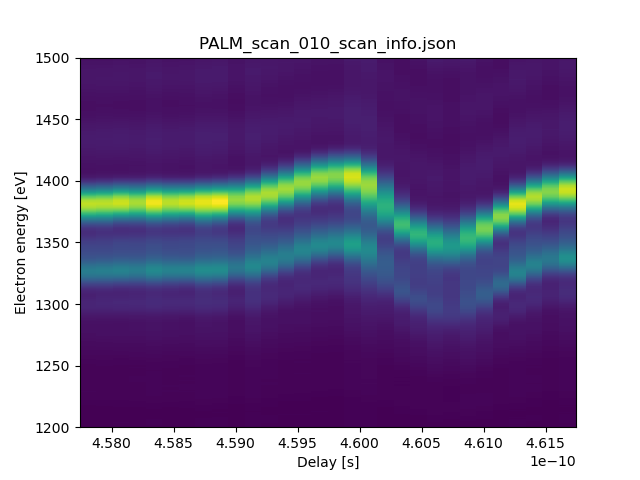

In [6]:
fig = plt.figure()
plt.pcolormesh(StagePOS[:,0], palm.energy_range, np.transpose(eVIntP.mean(axis=1)))
plt.xlabel('Delay [s]')
plt.ylabel('Electron energy [eV]')
plt.title(fn_json.split('/')[-1])
plt.show()

 ### Now calculate t0 and calibration factor with the fit

t0 is at 4.600774853252207e-10 s
Max streak is 56.878439219609845 eV
t0 from phase is at 4.604677402937231e-10 s
Calibration factor is -18.913301646032846 eV/fs
25699.559222049527


<IPython.core.display.Javascript object>


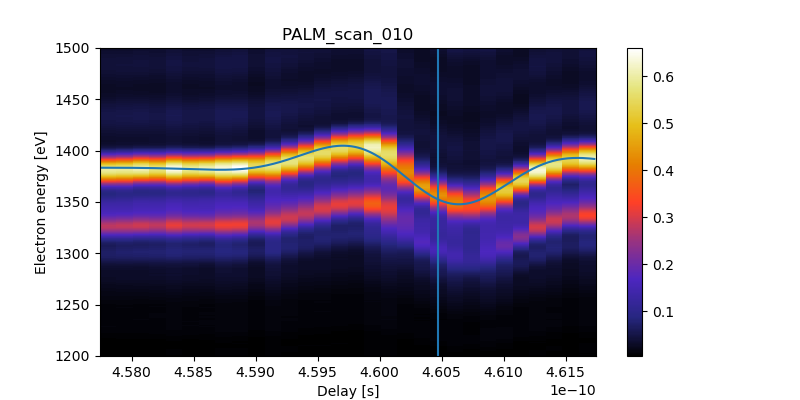

Scan PALM_scan_010, t0 from phase = 4.604677402937231e-10 and peak-to-peak streak of 57.08 eV


In [7]:
### Load is done, now run this cell to calculate the calibration factor (eV2fs)
### For p18182 (5 keV) found -28.240766953955095 eV/fs
### For p18389 (12 keV) found -4.610191678065906 eV/fs

# determining t0 and peak-to-peak distance
streak=np.transpose(np.array([StagePOS[:,0], palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)]]))
streakDerivative=np.transpose(np.array([[np.mean(t) for t in np.transpose([streak[:-1,0],streak[1:,0]])],np.diff(streak[:,1])/np.diff(streak[:,0])]))
#streakDerivative=np.transpose(np.array([streak[:-1,0],np.diff(streak[:,1])/np.diff(streak[:,0])]))
t0=[t[0] for t in streakDerivative if t[1]==min(streakDerivative[:,1])][0]

print("t0 is at {} s".format(t0))
print("Max streak is {} eV".format(max(np.array([t for t in streak if t[0]<t0])[:,1])-min(np.array([t for t in streak if t[0]>t0])[:,1])))

#Now fit with fit function
param_bounds = ([300,10,5.4e-10,1e-13,2e12,0],[600,500,5.5e-10,3e-12,4e12,np.inf])
parameters,extras = curve_fit(fitThz,StagePOS[:,0],palm.energy_range[np.argmax(np.transpose(eVIntP.mean(axis=1)),axis =0)], 
                              p0 = [np.min(palm.energy_range), 50, t0,2e-12,2.8e12,1])#,bounds=param_bounds)
# make the derivative 
dx = StagePOS[2,0]-StagePOS[1,0]
d_fitTHz_dx = np.gradient(fitThz(StagePOS[:,0],*parameters), dx)

max_y = np.max(np.gradient(fitThz(StagePOS[:,0],*parameters)))  # Find the maximum y value
max_x = np.argmin(np.gradient(fitThz(StagePOS[:,0],*parameters)))  # Find the maximum y value

# t0 from the phase fit 
t0_from_phase = parameters[2] + (parameters[4]*parameters[5])**-1 

calibrationLineSlope=np.interp(t0_from_phase,StagePOS[:,0],d_fitTHz_dx)
calibrationLineIntercept=np.interp(t0_from_phase,StagePOS[:,0],fitThz(StagePOS[:,0],*parameters))-calibrationLineSlope*t0_from_phase
ev2fsCalib = 1/(calibrationLineSlope*1e-15)
#print(max_x, max_y)
print ("t0 from phase is at {} s".format(t0_from_phase))
print ("Calibration factor is {} eV/fs".format(ev2fsCalib))
#print(parameters[2])
#print([calibrationLineSlope,calibrationLineIntercept,t0_from_phase])
print (calibrationLineIntercept)
# Trace from fit
xS=np.arange(np.min(StagePOS[:,0]),np.max(StagePOS[:,0]),(np.max(StagePOS[:,0])-np.min(StagePOS[:,0]))/300)
ySFitted=[fitThz(x, parameters[0],parameters[1],parameters[2],parameters[3],parameters[4],parameters[5]) for x in xS]

# Trace line 
#Trace_lin_fit = calibrationLineSlope * 


# Plot
fig = plt.figure(figsize=(8,4))
plt.pcolormesh(StagePOS[:,0], palm.energy_range, np.transpose(eVIntP.mean(axis=1)), cmap='CMRmap')
plt.colorbar()
plt.plot(xS,ySFitted)
plt.axvline(t0_from_phase)
plt.xlabel('Delay [s]')
plt.ylabel('Electron energy [eV]')
plt.title(scan_name)
plt.show()
PeakToPeak = np.max(ySFitted)-np.min(ySFitted)
print('Scan {}, t0 from phase = {} and peak-to-peak streak of {} eV'.format(scan_name, t0_from_phase, np.round(PeakToPeak,2)))

In [8]:
DIR = "/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/"

!ls -lah -rt $DIR | grep BSREAD

!hostname

listfile = os.listdir(DIR)
number_files = len(listfile)
print ("There are",number_files," BSREAD files in the folder", DIR)

-rw-r--r--.   1 root p18442 1.2G Feb  1 10:38 run_001674.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:39 run_001675.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:40 run_001676.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:42 run_001677.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:44 run_001678.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:46 run_001679.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:48 run_001680.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:50 run_001681.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:51 run_001682.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:53 run_001683.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:55 run_001684.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:57 run_001685.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 10:59 run_001686.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 11:00 run_001687.BSREAD.h5
-rw-r--r--.   1 root p18442 1.2G Feb  1 11:03 run_001688.BSREA

In [27]:
# Analyse a single file, no dark / light selection of the shots!!

fff = DIR + "run_001677.BSREAD.h5"
#print (os.path.isfile(fileName))

with h5py.File(fff, 'r') as fileName:
    fileName = load_data._get_data(fileName)
    check = fileName["SAR-CVME-TIFALL5:EvtSet/is_data_present"][:]

#pulse_id, delays, pulse_lengths, debug_data = palm.process_hdf5_file(fileName, debug=True)

pulse_id, delays, _, (input_data, lags, cross_corr, _) = palm.process_hdf5_file(fff, debug=True)
ev2fsCalib = -18.913301646032846
delays_fs = delays * ev2fsCalib

Delay for shot 6 = -434.27741148219155
0.0166015625
59.5985137705537


<IPython.core.display.Javascript object>


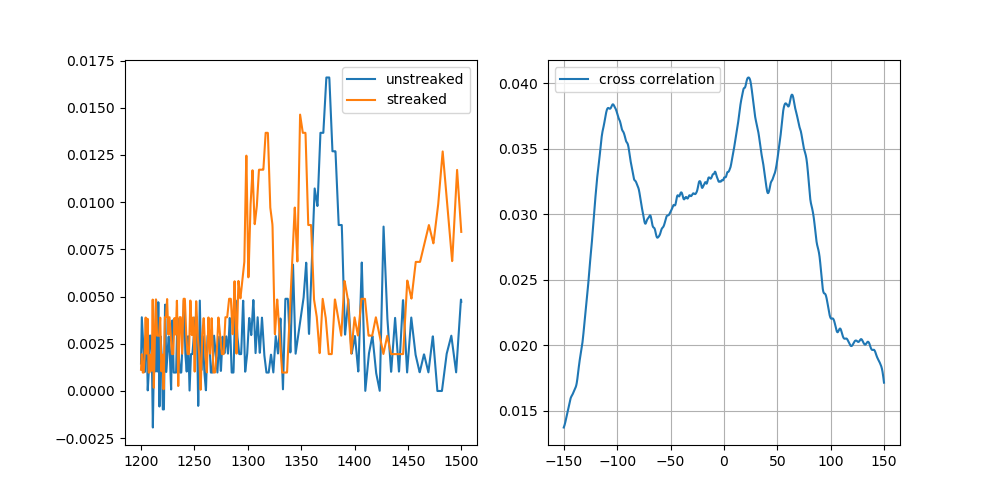

In [31]:
# Check one shot (be careful, could be a dark one!!) to see the TOF peak and cross correlation

shot = 6

print ('Delay for shot {} = {}'.format(shot, delays[shot]*ev2fsCalib))
print (np.amax(input_data['0'],axis=1)[shot])
print (cross_corr[shot].sum())

plt.figure(figsize= (10,5))
plt.subplot(121)
plt.plot(palm.energy_range, input_data['0'][shot], label="unstreaked")
plt.plot(palm.energy_range, input_data['1'][shot], label="streaked")
plt.legend(loc="best")

plt.subplot(122)
plt.plot(lags, cross_corr[shot], label="cross correlation")
plt.legend(loc="best")
plt.grid()

# Analyse a series of files

In [37]:
datalist = glob.glob(DIR + "*.BSREAD.h5")
datalist = sorted(datalist)
datalist

['/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001674.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001675.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001676.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001677.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001678.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001679.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001680.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001681.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001682.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001683.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001684.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001685.BSREAD.h5',
 '/sf/alvra/data/p18442/raw/scan_data/timescan_2840e

## Next is for a YAG scan (FEL/pump --- laser/probe)

In [24]:
datalist = glob.glob(DIR + "*.BSREAD.h5")
datalist = sorted(datalist)

#ev2fsCalib= -20.723024835035712 eV/fs    # This is from THz scan_508, p18182
#ev2fsCalib= -18.913301646032846 eV/fs    # This is from THz scan_010, p18442


Delays_PALM_all = []
Delays_mean = []
cross_corr_all = []
str_OK = []
ref_OK = []
pulseID_filter = []
pulseID_first = []
run_number = []

nshots = None

for fileName in datalist:
    testdata = load_data.check_files_and_data(fileName)
    
    if (testdata):# and (i!=12):
        with h5py.File(fileName, 'r') as BS_file:
#            clear_output(wait=True)
            print ("Processing file {}". format(fileName))
            run_number.append(int(fileName.split('_')[-1].split('.')[0]))
            data = load_data._get_data(BS_file)
            FEL = data["SAR-CVME-TIFALL5:EvtSet/data"][:nshots,48]
            Laser = data["SAR-CVME-TIFALL5:EvtSet/data"][:nshots,18]
            Darkshot = data["SAR-CVME-TIFALL5:EvtSet/data"][:nshots,21]
        
            pulse_id_PALM, delays_PALM_eV, _, (input_data, lags, cross_corr, _) = \
                                                palm.process_hdf5_file(fileName, debug=True)
                
            delays_PALM_fs = delays_PALM_eV * ev2fsCalib
            pulseID_first.append(pulse_id_PALM[0]) 
                        
            reprate_light, reprate_dark = load_data.load_reprates_TIMESCANS(fileName, modulo = 4)
            beamOK = (np.amax(input_data['0'],axis=1) > 0.0)# & (delays !=0.0)
            
            print (reprate_light.shape, reprate_dark.shape, beamOK.shape)
                       
            (reprate_light, beamOK, pulse_id_PALM, delays_PALM_fs, input_data['0'], input_data['1'], cross_corr) = \
                        load_data._cut_to_shortest_length \
            (reprate_light, beamOK, pulse_id_PALM, delays_PALM_fs, input_data['0'], input_data['1'], cross_corr)
            
            delays_beamOK_light = delays_PALM_fs[beamOK & reprate_light]
            refData_OK = input_data['0'][beamOK & reprate_light]
            StrData_OK = input_data['1'][beamOK & reprate_light]
            cross_corr_OK = cross_corr[beamOK & reprate_light]
            pulseID_OK = pulse_id_PALM[beamOK & reprate_light]
        
            ref_OK.append(refData_OK)
            str_OK.append(StrData_OK)
            print ('All ok, shape is {}'.format(delays_beamOK_light.shape))
            Delays_PALM_all.append(delays_beamOK_light)
            cross_corr_all.append(cross_corr_OK)
            pulseID_filter.append(pulseID_OK)
        
        Delays_mean.append(np.mean(delays_beamOK_light))
            
        print ("Run {}, Pulse ID = {} ----- mean delay = {} fs".format(fileName.split('_')[-1].split('.')[0], pulse_id[0], np.round(np.mean(delays_beamOK_light),3)))#, fileName,"pulseID =",pulse_id[0],)
        
Delays_PALM_all = np.asarray(Delays_PALM_all)
Delays_mean = np.asarray(Delays_mean)
cross_corr_all = np.asarray(cross_corr_all)
ref_OK = np.array(ref_OK)
str_OK = np.array(str_OK)
pulseID_filter = np.array(pulseID_filter)
#pulseID_first = np.array(pulseID_first)
print ("Job done!")
print ("Calibration factor used is {} eV/fs".format(ev2fsCalib))

Processing file /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001674.BSREAD.h5
Found 9999 shots in the file
Load 9996 shots
(9996,) (9996,) (9999,)
All ok, shape is (2499,)
Run 001674, Pulse ID = 10880355186 ----- mean delay = -117.318 fs
Processing file /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001675.BSREAD.h5
Found 9999 shots in the file
Load 9996 shots
(9996,) (9996,) (9999,)
All ok, shape is (2499,)
Run 001675, Pulse ID = 10880355186 ----- mean delay = -122.044 fs
Processing file /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001676.BSREAD.h5
Found 9999 shots in the file
Load 9996 shots
(9996,) (9996,) (9999,)
All ok, shape is (2499,)
Run 001676, Pulse ID = 10880355186 ----- mean delay = -93.844 fs
Processing file /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001677.BSREAD.h5
Found 9999 shots in the file
Load 9996 shots
(9996,) (9996,) (9999,)
All ok, shape is (2499,)
Run 001677, Pulse ID = 10880355186 ----- mean delay = -120.637 

Found 9999 shots in the file
Load 9996 shots
(9996,) (9996,) (9999,)
All ok, shape is (2499,)
Run 001707, Pulse ID = 10880355186 ----- mean delay = -5.057 fs
Processing file /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001708.BSREAD.h5
Found 9999 shots in the file
Load 9996 shots
(9996,) (9996,) (9999,)
All ok, shape is (2499,)
Run 001708, Pulse ID = 10880355186 ----- mean delay = 14.198 fs
Processing file /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001709.BSREAD.h5
Found 9999 shots in the file
Load 9996 shots
(9996,) (9996,) (9999,)
All ok, shape is (2499,)
Run 001709, Pulse ID = 10880355186 ----- mean delay = -27.707 fs
Processing file /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001710.BSREAD.h5
Found 9999 shots in the file
Load 9996 shots
(9996,) (9996,) (9999,)
All ok, shape is (2499,)
Run 001710, Pulse ID = 10880355186 ----- mean delay = 6.369 fs
Processing file /sf/alvra/data/p18442/raw/scan_data/timescan_2840eV_6/run_001711.BSREAD.h5
Foun

In [25]:
Delays_PALM_all.shape

(43, 2499)

<IPython.core.display.Javascript object>


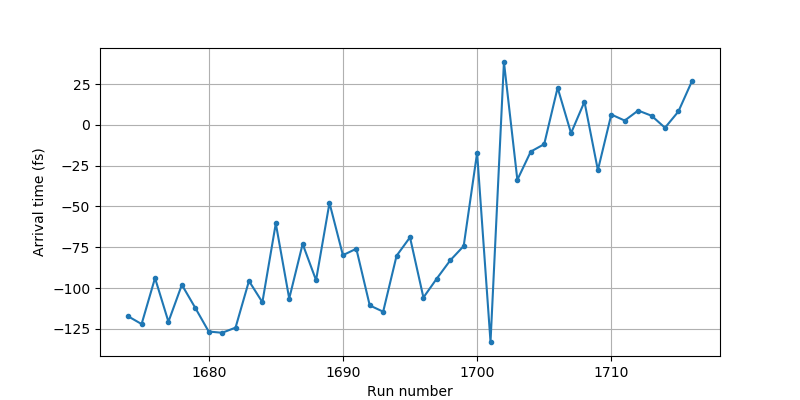

In [26]:
#xaxis = np.linspace(553, 692, (692 - 553)+1)

plt.figure(figsize=(8,4))
plt.plot(run_number, Delays_mean, label = 'mean arrival time', marker ='.')
plt.ylabel('Arrival time (fs)')
plt.xlabel('Run number')
plt.grid()

plt.show()

In [52]:
Total_light_1D = np.hstack(delays_Light_all)
print (Total_light_1D.shape)

Total_pulseIDS = np.hstack(pulseID_filter)
print (Total_pulseIDS.shape)

Total_strData = np.vstack(str_OK)
Total_refData = np.vstack(ref_OK)
print (Total_strData.shape)

Total_corrData = np.vstack(cross_corr_all)
print (Total_corrData.shape)

(2454,)
(2454,)
(2454, 2000)
(2454, 2000)


<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \s
<ipython-input-64-dc0fc91f2c79>:6: DeprecationWarning: invalid escape sequence \s
  label= '$\sigma={}$ fs, mean={} fs'.format(np.round(Total_light_1D.std(),2),np.round(Total_light_1D.mean(),2)), alpha=0.5)


<IPython.core.display.Javascript object>


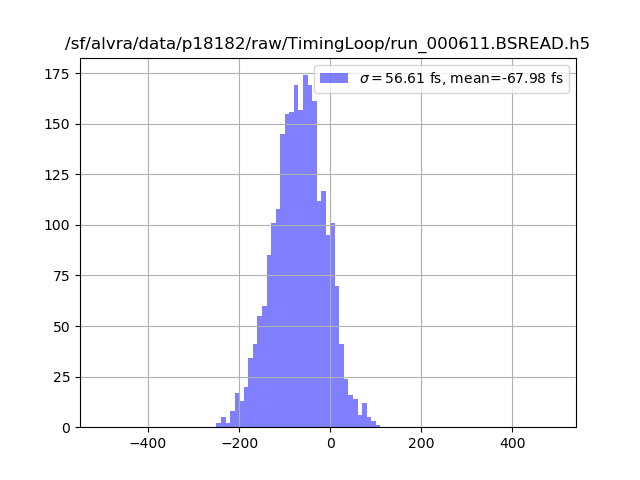

56.612871728278186
-67.97831903737222


In [64]:
num_bins =125
plt.figure()

#plt.hist(Total_light_1D, bins =np.arange(-500,500,10), facecolor='blue', label= r'$\sigma=%d$ fs' %Total_light_1D.std(), alpha=0.5)
plt.hist(Total_light_1D, bins =np.arange(-500,500,10), facecolor='blue', \
         label= '$\sigma={}$ fs, mean={} fs'.format(np.round(Total_light_1D.std(),2),np.round(Total_light_1D.mean(),2)), alpha=0.5)


plt.title(fileName)
plt.legend(loc='upper right')
#plt.text(-300,130,'Mean=%d'%Total_light_1D.mean())
plt.grid()

print (Total_light_1D.std())
print (Total_light_1D.mean())

plt.show()

In [ ]:
saveDir = "/das/work/p17/p17569/alvra_beamline_scripts/ProcessedData/"    # dest folder (needs to exist)
fn = str(saveDir + "Runs_451_513.h5")

hf = h5py.File(fn, 'w')
hf.create_dataset('Total_light_1D', data=Total_light_1D)
hf.create_dataset('Total_pulseIDS', data=Total_pulseIDS)
hf.create_dataset('Total_strData', data=Total_strData)
hf.create_dataset('Total_refData', data=Total_refData)
hf.create_dataset('Total_corrData', data=Total_corrData)
hf.close()

In [38]:
itemindex = np.where(Total_light_1D==66.05130091)

In [39]:
import pandas as pd
#input_data_max = np.amax(input_data['0'],axis=1)
df = pd.DataFrame(Total_light_1D)
Avg = df.rolling(300).mean()

<IPython.core.display.Javascript object>


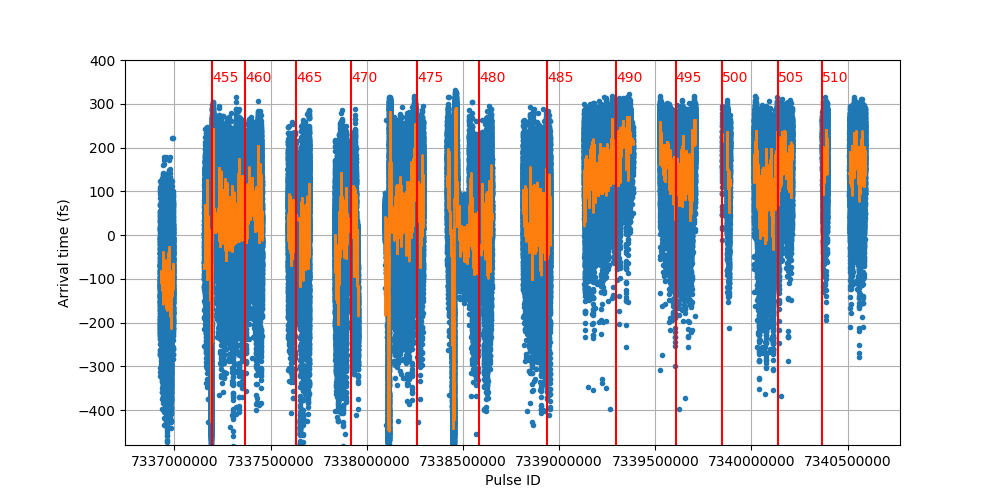

In [40]:
plt.figure(figsize= (10,5))
#plt.plot(Total_light_1D[0::1000])
plt.plot(Total_pulseIDS, Total_light_1D[:],'.')
#plt.plot(Total_light_1D[:],'.')

plt.plot(Total_pulseIDS, Avg,'.', ms=1 )


for xc in pulseID_first:
    if run_number[pulseID_first.index(xc)]%5 ==0:
        plt.axvline(x=xc, color = 'r')
        #plt.text(xc,200, pulseID_first.index(xc)+start_index,color = 'r')
        plt.text(xc,350, run_number[pulseID_first.index(xc)],color = 'r')

plt.ylabel("Arrival time (fs)")
#plt.xlabel("shot number")
plt.xlabel("Pulse ID")

plt.ticklabel_format(useOffset=False, style='plain')
plt.ylim((-480,400))
plt.grid()


<IPython.core.display.Javascript object>


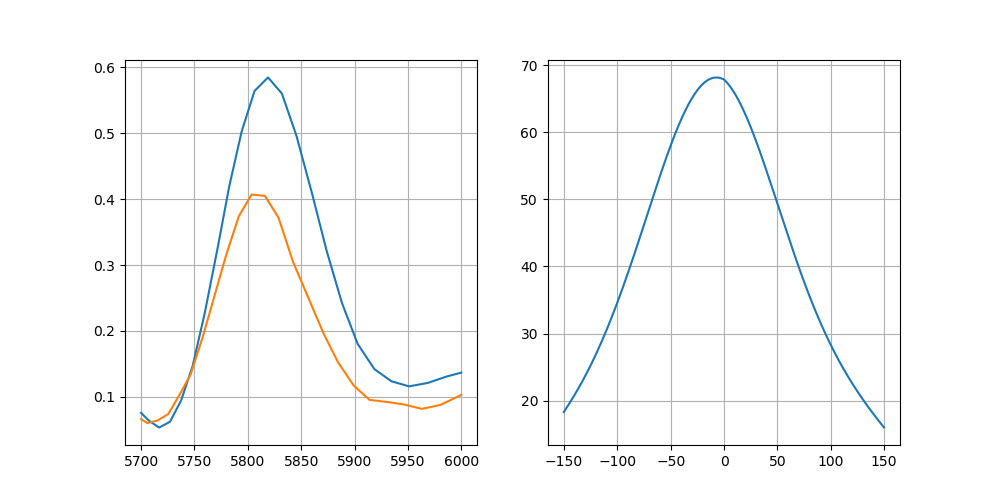

IndexError: index 450000 is out of bounds for axis 0 with size 39997

In [45]:
shot = 450000
plt.figure(figsize= (10,5))


plt.subplot(121)
plt.plot(palm.energy_range, Total_strData[shot])
plt.plot(palm.energy_range, Total_refData[shot])
plt.grid()

plt.subplot(122)
plt.plot(lags, Total_corrData[shot])
plt.grid()

plt.show()
print ("pulseID=",pulse_id[shot],"delay=",Total_strData[shot])

In [208]:
len(input_data['0'][input_data_max > 0.1])

6953

In [ ]:
pulse_id, delays, _, (input_data, lags, cross_corr, _) = res

8041925336


<IPython.core.display.Javascript object>


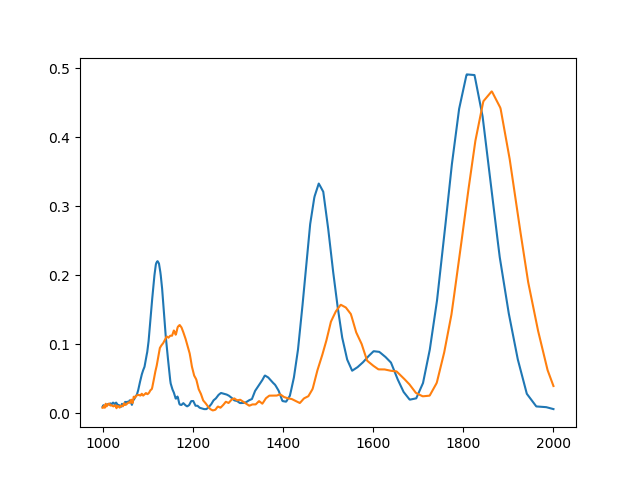

In [11]:
# Plot converted input data (eTOF time bins -> energy)
shot = 2
print (pulse_id[shot])
plt.figure()
plt.plot(palm.energy_range, input_data['0'][shot])
plt.plot(palm.energy_range, input_data['1'][shot])


In [7]:
cross_corr.shape

(39997, 1000)

<IPython.core.display.Javascript object>


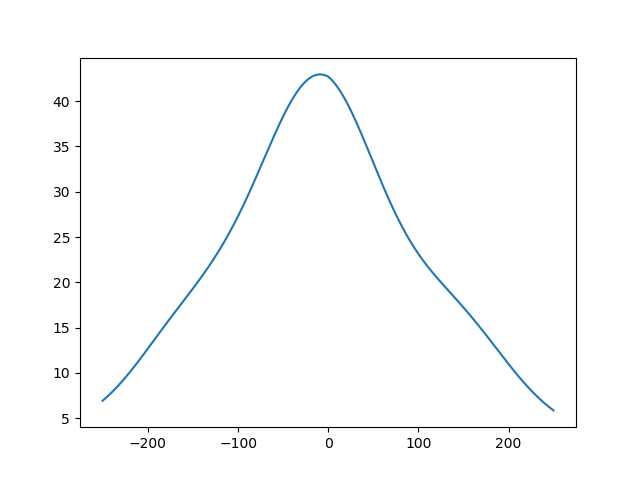

-9.009009009008878


In [168]:
# Plot cross-correlation results
plt.figure()
plt.plot(lags, cross_corr[shot])
print (delays[shot])

In [121]:
delays[6101]

-250.25025025025025

In [57]:
reprate_dark = pulse_id%20 == 0
reprate_light = ((pulse_id%4 == 0) & (pulse_id%20 != 0))
reprate_FEL = pulse_id%4 == 0

pulse_ids_light = pulse_id[reprate_light]
pulse_ids_dark = pulse_id[reprate_dark]

delays_light = delays[reprate_light]
delays_dark = delays[reprate_dark]

In [58]:
print (pulse_id.shape)
print (pulse_ids_light.shape)
print (pulse_ids_dark.shape)

(39997,)
(8000,)
(2000,)


<IPython.core.display.Javascript object>


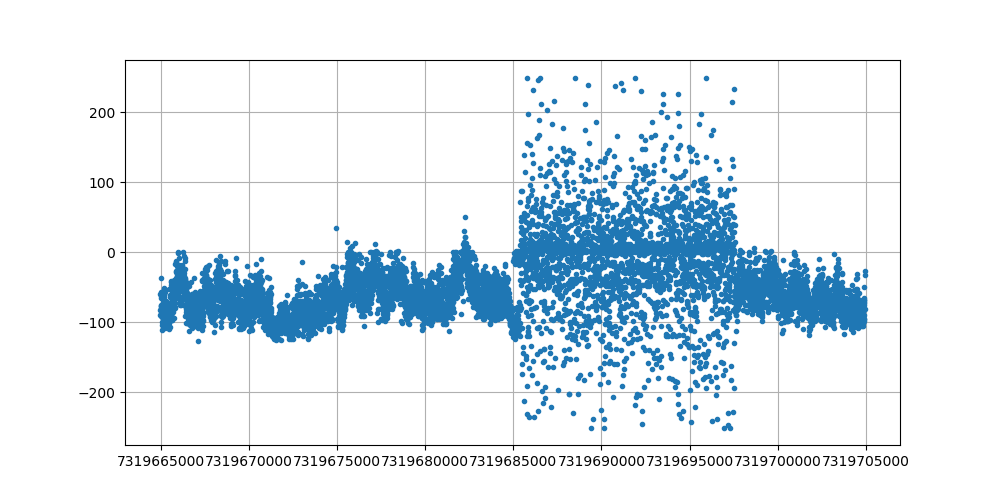

In [59]:
plt.figure(figsize= (10,5))
plt.plot(pulse_ids_light, delays_light, '.')

plt.ticklabel_format(useOffset=False, style='plain')
plt.grid()

<IPython.core.display.Javascript object>


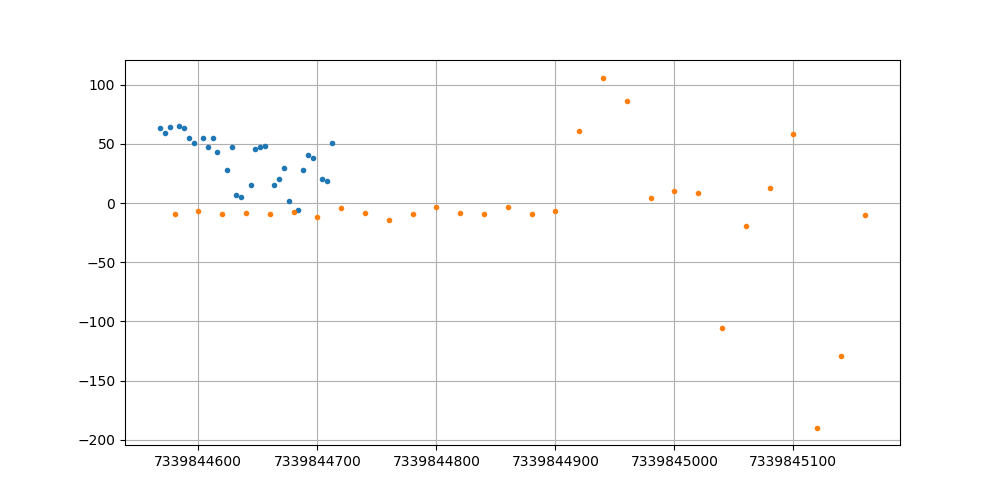

In [142]:
plt.figure(figsize= (10,5))
plt.plot(pulse_ids_light[0:30], delays_light[0:30], '.')
plt.plot(pulse_ids_dark[0:30], delays_dark[0:30], '.')

plt.ticklabel_format(useOffset=False, style='plain')
plt.grid()
#ind_good = pulse_id%..

In [163]:
print (delays_light.mean(), delays_light.std())

5.4278028028028045 77.2191535138822


In [61]:
513 - 450

63